# Lab Three: Multi-modal and Multi-task

#### CS8321: Neural Networks and Machine Learning
    
Johnathan Barr - 39854013
<br>
Will Lacey - 45906124

## Lab Description
<em>In this lab, you will implement a multi-task network (possibly multi-modal) that classifies interactions between compounds/ ligands with proteins in the ChEMBL database (https://www.ebi.ac.uk/chembl/). The objective is to classify which ligands bind to which targets. Each target will be a separate task working from a  shared ligand representation. </em>

## Import Modules and Initialization

Before we begin, let's import essential packages for data analysis.

In [1]:
import numpy as np

import pandas as pd

from rdkit import Chem

import sklearn
from sklearn.datasets.base import Bunch

import warnings
warnings.simplefilter('ignore')

RDKit WARNING: [13:16:31] Enabling RDKit 2019.09.3 jupyter extensions
/Users/Johnathan/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Downloading the ChEMBL Dataset

<em>[<strong>10 points</strong>] Download the ChEMBL database or setup queries to download a subset of the database. An already processed version of the dataset is available here (thanks to Niraj Verma): https://smu.box.com/s/smqmwlef0yehpieicwxqdr99k7f9ru04</em>

In [ ]:
# export data as .npy
f = open('./data.csv', 'r', encoding="ISO-8859-1")
lines = f.readlines()
f.close()


flis = [] # will have [id, ic50_val, unit, target, smiles] 

for line in lines[1:]: # first line contains the headers (therefore skiped)
    lis = line.strip().split(',')

    if len(lis) < 36:
        continue
    
    
    #print (lis[0], lis[3], lis[8], lis[36])
    # [id, ic50_val, unit, target, smiles]

    flis.append([lis[0], lis[3], lis[4], lis[8], lis[36]])
    #break

# I have no idea why python adds \x00 to each string
# Therefoe I removed it

for i in range (len(flis)):
    flis[i] = [j.replace('\x00','') for j in flis[i]]
    flis[i] = [j.replace('"','') for j in flis[i]]

# Some of the data have smiles or IC50 missing
# So I removed them as well
list = []
for i in flis:
    if len(i[1]) != 0 and len(i[-1]) != 0:
        #print (i)
        list.append(i)

X, t, y = [], [], []
for i in list:
    if i[2] == 'nM':
        if len(i[-1]) == 0 or len(i[-2]) ==0 or len(i[1]) ==0:
            print ('Thers a problem !!')
        X.append(i[-1])
        t.append(i[-2])
        y.append(i[1])

# smiles is the string representation of each ligand
# target is the protein where ligand binds (treat it as different schools)
# ic50 is the score
np.save('data/data.npy', {'smiles':X, 'target':t, 'ic50':y})

In [2]:
data = np.load('./data.npy', allow_pickle=True)

## Preprocessing the Data

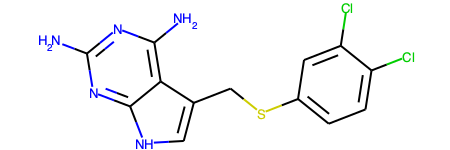

In [3]:
# loads the data into a pandas dataframe
df = pd.DataFrame(data.tolist())

# utilize RDKIT
m_smile = df['smiles'].get(0)
m = Chem.MolFromSmiles(m_smile)
m

In [4]:
counts_series = df['target'].value_counts()
len(counts_series)

67184

In [5]:
df

smiles         target  \
0                Nc1nc(N)c2c(CSc3ccc(Cl)c(Cl)c3)c[nH]c2n1   CHEMBL664913   
1                       NC(=S)\N=N\c1c(O)[nH]c2ccc(I)cc12   CHEMBL812106   
2       [Cl-].C[N+](C)(CCCN1c2ccccc2Sc3ccc(Cl)cc13)Cc4...   CHEMBL811877   
3             COc1cc(OC)cc(c1)N(C)Cc2c[nH]c3nc(N)nc(O)c23   CHEMBL664920   
4                         COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC   CHEMBL664913   
...                                                   ...            ...   
747912  Cn1cc(cn1)S(=O)(=O)N2CCC3=Cc4c(C[C@@]3(C2)C(=O...  CHEMBL4051182   
747913  CN(C)CCCNc1cc(ncn1)C2(CC2)C(=O)Nc3cc(ccc3C)C(=...  CHEMBL4050074   
747914  CN1CCN(Cc2ccc(NC(=O)c3n[nH]cc3Nc4ncnc5sc(C)cc4...  CHEMBL4059187   
747915  CN1CCN(Cc2ccc(NC(=O)c3n[nH]cc3Nc4ncnc5[nH]ccc4...  CHEMBL4059187   
747916  C(CCN(C[C@H]1Cc2ccccc2CN1)[C@H]3CCCc4cccnc34)C...  CHEMBL4059170   

         ic50  
0       11600  
1        9000  
2       17900  
3        4200  
4        2700  
...       ...  
747912    210  
747913   33.8  
747914  0.384  
747915   0.27  
747916   2720  

[747917 rows x 3 columns]

## Binarize the Binding Affinity

<em>[<strong>5 points</strong>] Binarize the binding affinity for each ligand in the assay. That is, convert the continuous measure of binding to binary. You should use the column 'IC50' for this calculation. Anything below 300 nM should be considered as an active binding. Anything above 10 uM should be considered non-binding (inactive). </em>

In [6]:
def binarize_affinity(value):
    value = float(value)
    if value < 300.0:
        return 1
    elif value > 10000.0:
        return 0
    else:
        return None

In [7]:
df['ic50'] = df['ic50'].apply(binarize_affinity)
df = df[df['ic50'].notna()]

In [8]:
df

smiles         target  ic50
0                Nc1nc(N)c2c(CSc3ccc(Cl)c(Cl)c3)c[nH]c2n1   CHEMBL664913   0.0
2       [Cl-].C[N+](C)(CCCN1c2ccccc2Sc3ccc(Cl)cc13)Cc4...   CHEMBL811877   0.0
5          Cc1c(CN(C=O)c2ccc(Cl)c(Cl)c2)cnc3nc(N)nc(N)c13   CHEMBL665696   1.0
6                       Cc1ccc2[nH]c(O)c(\N=N\C(=N)S)c2c1   CHEMBL805131   0.0
7                   CN(Cc1ccc2nc(N)nc(N)c2n1)c3cccc(Cl)c3   CHEMBL665702   1.0
...                                                   ...            ...   ...
747910        C[C@@H](Oc1cc2ccn(CCC(=O)O)c2cc1Cl)c3ccccn3  CHEMBL4051432   1.0
747912  Cn1cc(cn1)S(=O)(=O)N2CCC3=Cc4c(C[C@@]3(C2)C(=O...  CHEMBL4051182   1.0
747913  CN(C)CCCNc1cc(ncn1)C2(CC2)C(=O)Nc3cc(ccc3C)C(=...  CHEMBL4050074   1.0
747914  CN1CCN(Cc2ccc(NC(=O)c3n[nH]cc3Nc4ncnc5sc(C)cc4...  CHEMBL4059187   1.0
747915  CN1CCN(Cc2ccc(NC(=O)c3n[nH]cc3Nc4ncnc5[nH]ccc4...  CHEMBL4059187   1.0

[477543 rows x 3 columns]

## Featurize each Ligand
<em>[<strong>10 points</strong>] Featurize each ligand using RDKit (https://www.rdkit.org). This will convert the ligand representation into a binary vector of features. Mention any hyper parameters you use. </em>

In [9]:
# function to take the top x targets in the dataset based on number of occurances
def top(x):
    # take the top, most tested proteins, sorting them from most to least tested
    counts_series = df['target'].value_counts()

    # grab the target names of the top 100 most tested proteins
    top_targets = counts_series[0:x].index.values.tolist()

    # retain only top 100 proteins in the dataframe, remove others
    return df[df['target'].isin(top_targets)]

In [10]:
def vectorize_binary_fingerprint(binary_fingerprint):
    vector = []
    for i in binary_fingerprint:
        vector.append(int(i))
    return vector

# take top 150 targets to shrink dataset before featurization. But want more that 100 because will end up losing some to bad data
df = top(200)

smiles_data = df['smiles'].tolist()
target_data = df['target'].tolist()
ic50_data = df['ic50'].tolist()

In [11]:
df

smiles         target  ic50
67                        COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2   CHEMBL830839   1.0
68                   Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1   CHEMBL828662   1.0
69                   Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1   CHEMBL830839   1.0
71              COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1   CHEMBL828662   1.0
76                      CN(Cc1ccccc1)c2cnc3nc(N)nc(N)c3c2   CHEMBL830839   1.0
...                                                   ...            ...   ...
747441                                       Homo sapiens  CHEMBL3887900   1.0
747443                                                4.5  CHEMBL3887678   1.0
747446                                               9606  CHEMBL3887679   1.0
747457                             S=P(N1CC1)(N2CC2)N3CC3  CHEMBL4017550   0.0
747458  CN(C)S(=O)(=O)c1ccc2Sc3ccccc3\C(=C\CCN4CCN(C)C...  CHEMBL4017550   0.0

[62078 rows x 3 columns]

In [12]:
featurized_data = []

for smiles in smiles_data:
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        fingerprint = Chem.RDKFingerprint(molecule)
        binary_fingerprint = fingerprint.ToBitString()
        featurized_molecule = vectorize_binary_fingerprint(binary_fingerprint)
        featurized_data.append(featurized_molecule)
    else:
        featurized_data.append(None)

RDKit ERROR: [13:17:07] SMILES Parse Error: syntax error while parsing: BAO_0000019
RDKit ERROR: [13:17:07] SMILES Parse Error: Failed parsing SMILES 'BAO_0000019' for input: 'BAO_0000019'
RDKit ERROR: [13:17:07] SMILES Parse Error: syntax error while parsing: BAO_0000019
RDKit ERROR: [13:17:07] SMILES Parse Error: Failed parsing SMILES 'BAO_0000019' for input: 'BAO_0000019'
RDKit ERROR: [13:17:07] SMILES Parse Error: syntax error while parsing: BAO_0000019
RDKit ERROR: [13:17:07] SMILES Parse Error: Failed parsing SMILES 'BAO_0000019' for input: 'BAO_0000019'
RDKit ERROR: [13:17:07] SMILES Parse Error: syntax error while parsing: BAO_0000019
RDKit ERROR: [13:17:07] SMILES Parse Error: Failed parsing SMILES 'BAO_0000019' for input: 'BAO_0000019'
RDKit ERROR: [13:17:07] SMILES Parse Error: syntax error while parsing: BAO_0000019
RDKit ERROR: [13:17:07] SMILES Parse Error: Failed parsing SMILES 'BAO_0000019' for input: 'BAO_0000019'
RDKit ERROR: [13:17:07] SMILES Parse Error: syntax erro

In [13]:
df['featurized_smiles'] = featurized_data
df = df[df['featurized_smiles'].notna()]
df

smiles         target  \
67                        COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2   CHEMBL830839   
68                   Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1   CHEMBL828662   
69                   Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1   CHEMBL830839   
71              COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1   CHEMBL828662   
76                      CN(Cc1ccccc1)c2cnc3nc(N)nc(N)c3c2   CHEMBL830839   
...                                                   ...            ...   
747291   CC(C)(C)C(=O)CN1CC2CN(CCCNc3ccc(cc3)C#N)CC(C1)O2  CHEMBL4017550   
747316                        NC(=N)NC(=O)Cc1c(Cl)cccc1Cl  CHEMBL4028921   
747395  CC(C)[C@H](O)C(=O)N[C@@H](C)C(=O)N[C@@H]1C(=O)...  CHEMBL4017550   
747457                             S=P(N1CC1)(N2CC2)N3CC3  CHEMBL4017550   
747458  CN(C)S(=O)(=O)c1ccc2Sc3ccccc3\C(=C\CCN4CCN(C)C...  CHEMBL4017550   

        ic50                                  featurized_smiles  
67       1.0  [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, ...  
68       1.0  [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...  
69       1.0  [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...  
71       1.0  [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...  
76       1.0  [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...  
...      ...                                                ...  
747291   0.0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
747316   0.0  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...  
747395   0.0  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, ...  
747457   0.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
747458   0.0  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...  

[36467 rows x 4 columns]

## Filtering the Top 100 Targets

<em>[<strong>10 points</strong>] Filter the database to the top 100 targets in the database. You will need a definition of "top" such as the targets with the most assays. From these top 100 targets, save the ligands that have an assay result for each of the targets. </em>

In [14]:
df = top(100)

Load/read from file to avoid having to preprocess every time

In [16]:
# df.to_pickle("top_data.pkl")

In [ ]:
# df = pd.read_pickle("top_data.pkl")

In [18]:
top_targets = df['target'].value_counts().index.values.tolist()
top_targets

['CHEMBL2114881',
 'CHEMBL2114714',
 'CHEMBL1963941',
 'CHEMBL1963883',
 'CHEMBL3562022',
 'CHEMBL1614063',
 'CHEMBL1738498',
 'CHEMBL3881499',
 'CHEMBL1614432',
 'CHEMBL1613885',
 'CHEMBL4028923',
 'CHEMBL3880339',
 'CHEMBL3880337',
 'CHEMBL2218781',
 'CHEMBL3880338',
 'CHEMBL4028921',
 'CHEMBL4028924',
 'CHEMBL3705123',
 'CHEMBL1613799',
 'CHEMBL4028922',
 'CHEMBL1738424',
 'CHEMBL3880340',
 'CHEMBL1738407',
 'CHEMBL4017550',
 'CHEMBL3706327',
 'CHEMBL3880341',
 'CHEMBL3436039',
 'CHEMBL3436040',
 'CHEMBL1614547',
 'CHEMBL3436041',
 'CHEMBL3431934',
 'CHEMBL3880335',
 'CHEMBL3880334',
 'CHEMBL1614423',
 'CHEMBL3880344',
 'CHEMBL1964096',
 'CHEMBL3431931',
 'CHEMBL1614199',
 'CHEMBL1964000',
 'CHEMBL2114818',
 'CHEMBL2114719',
 'CHEMBL3880342',
 'CHEMBL1963965',
 'CHEMBL1119333',
 'CHEMBL1614549',
 'CHEMBL3734174',
 'CHEMBL3887033',
 'CHEMBL1614359',
 'CHEMBL1006579',
 'CHEMBL3707950',
 'CHEMBL2114737',
 'CHEMBL3882758',
 'CHEMBL3215171',
 'CHEMBL3883019',
 'CHEMBL3882757',
 'CHEMBL21

## Train a multi-task model

<em>[<strong>20 points</strong>] Train a multi-task model (one model for each target). Use an 80/20 split for each target.</em>

In [19]:
import sklearn
from sklearn.datasets.base import Bunch

tasks = dict()

for target in top_targets:
    target_rows = df.loc[df['target'] == target]
    tasks[target] = Bunch(data   = target_rows.featurized_smiles,
                          labels = target_rows.ic50)

In [23]:
len(tasks)

100

In [ ]:
from sklearn.model_selection import train_test_split
X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for x in tasks.keys():
    X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(tasks[x].data, 
                                                        tasks[x].labels, 
                                                        test_size=0.4,
                                                        random_state=42)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X[0].shape[0],))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

# make a dictionary of models for each task
models_mtl = dict()

for x in tasks.keys():
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='sgd', loss='mean_squared_error')
    models_mtl[x] = model

In [ ]:
%%time
EPOCHS = 20
from random import shuffle

all_keys = list(tasks.keys())
for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys)
    for x in all_keys:
        models_mtl[x].fit(X_train[x],y_train[x], verbose=0)

In [ ]:
%%time
y_mtl=[]
yhat_mtl=[]

for x in X_test.keys():
    yhat_mlp = models_mtl[x].predict(X_test[x])

    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

## Report the results

<em>[<strong>20 points</strong>] Report the results using AUC, BEDROC, and Enrichment factor. These metrics are easily calculated using the RDKit scoring library. Discuss the results (you will need to look up each evaluation metric to interpret the result). You may be interested in page 6 of the following document: https://www.dropbox.com/s/6je37ml475vg3ep/Srinivas2018ImplictDescriptorUnderReview.pdf?dl=0 </em>


In [ ]:
# look at 4.2 in the document

## Additional Analysis

<em>[<strong>10 points</strong>] Finally, you have free reign to perform any other analysis. A suggested analysis is to add an additional mode of input data such as another fingerprint for each ligand.</em>